# Data Prep

The goal of this notebook is to prep the data for the alignment task.  This includes computing audio features and generating a query list.

In [3]:
import numpy as np
import librosa as lb
import os
import os.path
from pathlib import Path
import multiprocessing
import glob

In [4]:
ANNOTATIONS_ROOT = Path('train_data/beat')
AUDIO_ROOT = ('Full_Alignment_Recordings')
FEATURES_ROOT = Path('features')
Scenario_1_files = 'Full_Alignment_Recordings/Scenario_1'
Scenario_2_files = 'Full_Alignment_Recordings/Scenario_2'
Scenario_3_files = 'Full_Alignment_Recordings/Scenario_3'
Scenario_4_files = 'Full_Alignment_Recordings/Scenario_4'

In [5]:
scenario1files = glob.glob(Scenario_1_files + "/*")
scenario2files = glob.glob(Scenario_2_files + "/*")
scenario3files = glob.glob(Scenario_3_files + "/*")
scenario4files = glob.glob(Scenario_4_files + "/*")
inFiles = []
for file in scenario1files:
    inFiles.append(file)
for file in scenario2files:
    inFiles.append(file)
for file in scenario3files:
    inFiles.append(file)
for file in scenario4files:
    inFiles.append(file)

print(len(inFiles))

8


In [6]:
if not os.path.exists(FEATURES_ROOT):
    os.mkdir(FEATURES_ROOT)

### Compute features on clean audio

First we compute features on the audio.

In [7]:
def compute_chroma_single(infile, outfile, sr = 22050, hop_length=512):
    y, sr = lb.core.load(infile, sr = sr)
    # F = lb.feature.chroma_cens(y, sr=sr, hop_length=hop_length)
    F = lb.feature.chroma_cqt(y, sr=sr, hop_length=hop_length, norm=2)
    np.save(outfile, F)
    return

In [8]:
for audio in inFiles:
    compute_chroma_single(audio, outfile)

NameError: name 'outfile' is not defined

In [9]:
def compute_chroma_batch(filelist, outdir, n_cores):

    # prep inputs for parallelization
    inputs = []
    with open(filelist, 'r') as f:
        for line in f:
            relpath = line.strip()
            reldir, fileid = os.path.split(relpath)
            featdir = outdir / reldir
            featdir.mkdir(parents=True, exist_ok=True)
            featfile = (featdir / fileid).with_suffix('.npy')
            audiofile = relpath
            if os.path.exists(featfile):
                print(f"Skipping {featfile}")
            else:
                inputs.append((audiofile, featfile))

    # process files in parallel
    pool = multiprocessing.Pool(processes = n_cores)
    pool.starmap(compute_chroma_single, inputs)

    return

In [10]:
compute_chroma_batch(Path("cfg_files/A_scenario.txt"),Path("scenario_feat"), 4)

Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/E207_Spr24/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/E207_Spr24/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/E207_Spr24/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/anaconda3/envs/E207_Spr24/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'compute_chroma_single' on <module '__main__' (built-in)>
Process SpawnPoolWorker-2:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/E207_Spr24/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/E207_Spr24/lib/python3.11/multiprocessing/process.py", 

KeyboardInterrupt: 

### Alignment

In [1]:
%matplotlib inline
%load_ext Cython

ModuleNotFoundError: No module named 'Cython'

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
import os.path
from pathlib import Path
import pickle
import multiprocessing
import time
import gc

In [13]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

import sys
import time


DTYPE_INT32 = np.int32
ctypedef np.int32_t DTYPE_INT32_t

DTYPE_FLOAT = np.float64
ctypedef np.float64_t DTYPE_FLOAT_t

cdef DTYPE_FLOAT_t MAX_FLOAT = float('inf')

# careful, without bounds checking can mess up memory - also can't use negative indices I think (like x[-1])
@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_Cost_To_AccumCostAndSteps(Cin, parameter):
    '''
    Inputs
        C: The cost Matrix
    '''


    '''
    Section for checking and catching errors in the inputs
    '''

    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] C
    try:
        C = np.array(Cin, dtype=DTYPE_FLOAT)
    except TypeError:
        print(bcolors.FAIL + "FAILURE: The type of the cost matrix is wrong - please pass in a 2-d numpy array" + bcolors.ENDC)
        return [-1, -1, -1]
    except ValueError:
        print(bcolors.FAIL + "FAILURE: The type of the elements in the cost matrix is wrong - please have each element be a float (perhaps you passed in a matrix of ints?)" + bcolors.ENDC)
        return [-1, -1, -1]

    cdef np.ndarray[np.uint32_t, ndim=1] dn
    cdef np.ndarray[np.uint32_t, ndim=1] dm
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=1] dw
    # make sure dn, dm, and dw are setup
    # dn loading and exception handling
    if ('dn'  in parameter.keys()):
        try:

            dn = np.array(parameter['dn'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dn (row steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "The type of the elements in dn (row steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dn = np.array([1, 1, 0], dtype=np.uint32)
    # dm loading and exception handling
    if 'dm'  in parameter.keys():
        try:
            dm = np.array(parameter['dm'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dm (col steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE: The type of the elements in dm (col steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        print(bcolors.FAIL + "dm (col steps) was not passed in (gave default value [1,0,1]) " + bcolors.ENDC)
        dm = np.array([1, 0, 1], dtype=np.uint32)
    # dw loading and exception handling
    if 'dw'  in parameter.keys():
        try:
            dw = np.array(parameter['dw'], dtype=DTYPE_FLOAT)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dw (step weights) is wrong - please pass in a 1-d numpy array that holds floats" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE:The type of the elements in dw (step weights) is wrong - please have each element be a float (perhaps you passed ints or a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.float64)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dw = np.array([1, 1, 1], dtype=DTYPE_FLOAT)
        print(bcolors.FAIL + "dw (step weights) was not passed in (gave default value [1,1,1]) " + bcolors.ENDC)


    '''
    Section where types are given to the variables we're going to use
    '''
    # create matrices to store our results (D and E)
    cdef DTYPE_INT32_t numRows = C.shape[0] # only works with np arrays, use np.shape(x) will work on lists? want to force to use np though?
    cdef DTYPE_INT32_t numCols = C.shape[1]
    cdef DTYPE_INT32_t numDifSteps = np.size(dw)

    cdef unsigned int maxRowStep = max(dn)
    cdef unsigned int maxColStep = max(dm)

    cdef np.ndarray[np.uint32_t, ndim=2] steps = np.zeros((numRows,numCols), dtype=np.uint32)
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost = np.ones((maxRowStep + numRows, maxColStep + numCols), dtype=DTYPE_FLOAT) * MAX_FLOAT

    cdef DTYPE_FLOAT_t bestCost
    cdef DTYPE_INT32_t bestCostIndex
    cdef DTYPE_FLOAT_t costForStep
    cdef unsigned int row, col
    cdef unsigned int stepIndex

    '''
    The start of the actual algorithm, now that all our variables are set up
    '''
    # initializing the cost matrix - depends on whether its subsequence DTW
    # essentially allow us to hop on the bottom anywhere (so could start partway through one of the signals)
    if parameter['SubSequence']:
        for col in range(numCols):
            accumCost[maxRowStep, col + maxColStep] = C[0, col]
    else:
        accumCost[maxRowStep, maxColStep] = C[0,0]

    # filling the accumulated cost matrix
    for row in range(maxRowStep, numRows + maxRowStep, 1):
        for col in range(maxColStep, numCols + maxColStep, 1):
            bestCost = accumCost[<unsigned int>row, <unsigned int>col] # initialize with what's there - so if is an entry point, then can start low
            bestCostIndex = 0
            # go through each step, find the best one
            for stepIndex in range(numDifSteps):
                #costForStep = accumCost[<unsigned int>(row - dn[<unsigned int>(stepIndex)]), <unsigned int>(col - dm[<unsigned int>(stepIndex)])] + dw[<unsigned int>(stepIndex)] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                costForStep = accumCost[<unsigned int>((row - dn[(stepIndex)])), <unsigned int>((col - dm[(stepIndex)]))] + dw[stepIndex] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                if costForStep < bestCost:
                    bestCost = costForStep
                    bestCostIndex = stepIndex
            # save the best cost and best cost index
            accumCost[row, col] = bestCost
            steps[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)] = bestCostIndex

    # return the accumulated cost along with the matrix of steps taken to achieve that cost
    return [accumCost[maxRowStep:, maxColStep:], steps]

@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_GetPath(np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost, np.ndarray[np.uint32_t, ndim=2] stepsForCost, parameter):
    '''

    Parameter should have: 'dn', 'dm', 'dw', 'SubSequence'
    '''

    cdef np.ndarray[unsigned int, ndim=1] dn
    cdef np.ndarray[unsigned int, ndim=1] dm
    cdef np.uint8_t subseq
    cdef np.int32_t startCol # added
    # make sure dn, dm, and dw are setup
    if ('dn'  in parameter.keys()):
        dn = parameter['dn']
    else:
        dn = np.array([1, 1, 0], dtype=DTYPE_INT32)
    if 'dm'  in parameter.keys():
        dm = parameter['dm']
    else:
        dm = np.array([1, 0, 1], dtype=DTYPE_INT32)
    if 'SubSequence' in parameter.keys():
        subseq = parameter['SubSequence']
    else:
        subseq = 0

    # added START
    if 'startCol' in parameter.keys():
        startCol = parameter['startCol']
    else:
        startCol = -1
    # added END

    cdef np.uint32_t numRows
    cdef np.uint32_t numCols
    cdef np.uint32_t curRow
    cdef np.uint32_t curCol
    cdef np.uint32_t endCol
    cdef DTYPE_FLOAT_t endCost

    numRows = accumCost.shape[0]
    numCols = accumCost.shape[1]

    # either start at the far corner (non sub-sequence)
    # or start at the lowest cost entry in the last row (sub-sequence)
    # where all of the signal along the row has been used, but only a
    # sub-sequence of the signal along the columns has to be used
    curRow = numRows - 1
    if subseq:
        curCol = np.argmin(accumCost[numRows - 1, :])
    else:
        curCol = numCols - 1

    # added - if specified, overrides above
    if startCol >= 0:
        curCol = startCol

    endCol = curCol
    endCost = accumCost[curRow, curCol]

    cdef np.uint32_t curRowStep
    cdef np.uint32_t curColStep
    cdef np.uint32_t curStepIndex


    cdef np.ndarray[np.uint32_t, ndim=2] path = np.zeros((2, numRows + numCols), dtype=np.uint32) # make as large as could need, then chop at the end
    path[0, 0] = curRow
    path[1, 0] = curCol

    cdef np.uint32_t stepsInPath = 1 # starts at one, we add in one before looping
    cdef np.uint32_t stepIndex = 0
    cdef np.int8_t done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)
    while not done:
        if accumCost[curRow, curCol] == MAX_FLOAT:
            print('A path is not possible')
            break

        # you're done if you've made it to the bottom left (non sub-sequence)
        # or just the bottom (sub-sequence)
        # find the step size
        curStepIndex = stepsForCost[curRow, curCol]
        curRowStep = dn[curStepIndex]
        curColStep = dm[curStepIndex]
        # backtrack by 1 step
        curRow = curRow - curRowStep
        curCol = curCol - curColStep
        # add your new location onto the path
        path[0, stepsInPath] = curRow
        path[1, stepsInPath] = curCol
        stepsInPath = stepsInPath + 1
        # check to see if you're done
        done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)

    # reverse the path (a matrix with two rows) and return it
    return [np.fliplr(path[:, 0:stepsInPath]), endCol, endCost]

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [29]:
def alignDTW(featfile1, featfile2, steps, weights, downsample, outfile = None, profile = False):

    F1 = np.load(featfile1) # 12 x N
    F2 = np.load(featfile2) # 12 x M
    if max(F1.shape[1], F2.shape[1]) / min(F1.shape[1], F2.shape[1]) >= 2: # no valid path possible
        if outfile:
            pickle.dump(None, open(outfile, 'wb'))
        return None
    times = []
    times.append(time.time())
    C = 1 - F1[:,0::downsample].T @ F2[:,0::downsample] # cos distance metric
    times.append(time.time())

    dn = steps[:,0].astype(np.uint32)
    dm = steps[:,1].astype(np.uint32)
    parameters = {'dn': dn, 'dm': dm, 'dw': weights, 'SubSequence': False}
    [D, s] = DTW_Cost_To_AccumCostAndSteps(C, parameters)
    times.append(time.time())
    [wp, endCol, endCost] = DTW_GetPath(D, s, parameters)
    times.append(time.time())
    if outfile:
        pickle.dump(wp, open(outfile, 'wb'))

    if profile:
        return wp, np.diff(times)
    else:
        return wp, D, C, s, parameters

## Idea 1 -- Visualization of the path and D matrix

In [30]:
scenario1Features = glob.glob("scenario_feat/Full_Alignment_Recordings/Scenario_1" + "/*")
scenario2Features = glob.glob("scenario_feat/Full_Alignment_Recordings/Scenario_2" + "/*")
scenario3Features = glob.glob("scenario_feat/Full_Alignment_Recordings/Scenario_3" + "/*")
scenario4Features = glob.glob("scenario_feat/Full_Alignment_Recordings/Scenario_4" + "/*")
steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
weights = np.array([2,3,3])
downsample = 1

wp1, D1, C1, s1, parameters1 = (alignDTW(scenario1Features[0], scenario1Features[1], steps, weights, downsample))
wp2, D2, C2, s2, parameters2 = (alignDTW(scenario2Features[0], scenario2Features[1], steps, weights, downsample))
wp3, D3, C3, s3, parameters3  = (alignDTW(scenario3Features[0], scenario3Features[1], steps, weights, downsample))
wp4, D4, C4, s4, parameters4 = (alignDTW(scenario4Features[0], scenario4Features[1], steps, weights, downsample))



In [16]:
wp1

array([[    0,     2,     4, ..., 13903, 13905, 13907],
       [    0,     1,     2, ..., 11021, 11022, 11023]], dtype=uint32)

In [17]:
D1.shape

(13908, 11024)

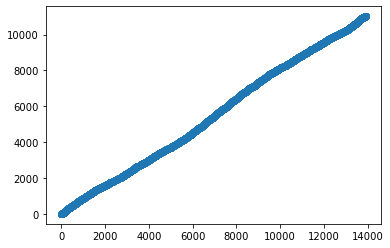

In [17]:
plt.scatter(wp1[0],wp1[1])
plt.show()

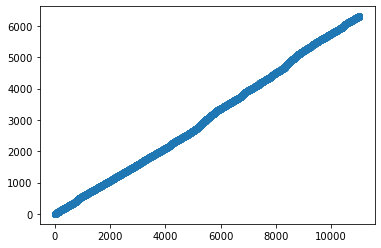

In [18]:
plt.scatter(wp2[0],wp2[1])
plt.show()

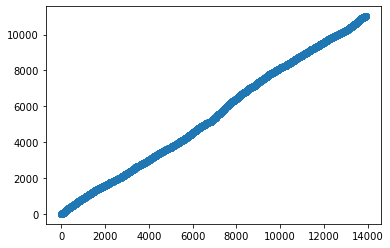

In [19]:
plt.scatter(wp3[0],wp3[1])
plt.show()

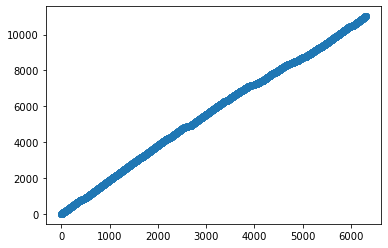

In [20]:
plt.scatter(wp4[0],wp4[1])
plt.show()

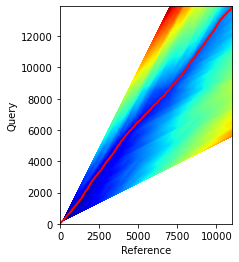

In [21]:
plt.xlabel('Reference')
plt.ylabel('Query')
x,y = wp1[0], wp1[1]
plt.plot(y,x, color='red', markersize=1, linewidth=2)
plt.imshow(D1, origin = 'lower', cmap='jet')

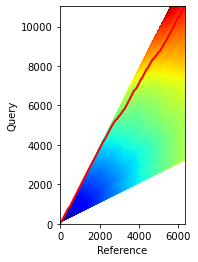

In [22]:
plt.xlabel('Reference')
plt.ylabel('Query')
x,y = wp2[0], wp2[1]
plt.plot(y,x, color='red', markersize=1, linewidth=2)
plt.imshow(D2, origin = 'lower', cmap='jet')

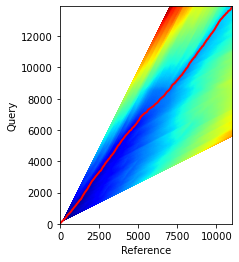

In [23]:
plt.xlabel('Reference')
plt.ylabel('Query')
x,y = wp3[0], wp3[1]
plt.plot(y,x, color='red', markersize=1, linewidth=2)
plt.imshow(D3, origin = 'lower', cmap='jet')

In [24]:
plt.xlabel('Reference')
plt.ylabel('Query')
x,y = wp4[0], wp4[1]
plt.plot(y,x, color='red', markersize=1, linewidth=2)
plt.imshow(D4, origin = 'lower', cmap='jet')

## Idea 2 -- Backtrace voting

In [28]:
def subsequenceDTW(C, steps, weights):
    '''
    Find the optimal subsequence path through cost matrix C.
    
    Arguments:
    C -- cost matrix of dimension (# query frames, # reference frames)
    steps -- a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    weights -- a vector of size L specifying the multiplicative weights associated 
                with each of the allowable transitions
                
    Returns:
    optcost -- the optimal subsequence path score
    path -- a matrix with 2 columns specifying the optimal subsequence path.  Each row 
            specifies the (row, col) coordinate.
    '''
    D = np.zeros(C.shape)
    B = np.zeros(C.shape, dtype=np.int8)

    ### START CODE BLOCK ###
    Mq, Mr = D.shape
    for i in range(0, Mq):
        for j in range(0, Mr):
            if i == 0:
                D[0,j] = C[0,j]
            else:
                possible_costs = np.zeros(steps.shape[0])
                for k in range(steps.shape[0]):
                    row_move, col_move = steps[k]
                    if i - row_move < 0 or j - col_move < 0:
                        possible_costs[k] = float('inf')
                    else:
                        possible_costs[k] = D[i - row_move, j - col_move] + C[i,j] * weights[k]
                min_index = np.argmin(possible_costs)
                D[i,j] = possible_costs[min_index]
                B[i,j] = min_index
    path = backtrace(D, B, steps)
    optcost = np.min(D[-1,:])
    ### END CODE BLOCK ###
    
    path = np.array(path)
    
    return D, B

In [31]:
ourD1, ourB1 = subsequenceDTW(C1, steps, weights)

In [ ]:
ourD1

In [ ]:
D1

In [ ]:
wp1_backtrace_list = []
for r in range(1, D1.shape[0]):
    for c in range(1, D1.shape[1]):
        wp_tmp, endCol_tmp, endCost_tmp = DTW_GetPath(D1[:r+1,:c+1], s1, parameters1)
        wp1_backtrace_list.append(wp_tmp)

NameError: name 'D1' is not defined

## Idea 3a -- Backtrace with offset

In [26]:
count = 0
for r in range(D1.shape[0]):
    for c in range(D1.shape[1]):
        if D1[r,c] != np.inf:
            count += 1

In [27]:
count

74581532

In [22]:
wp1[,]

SyntaxError: invalid syntax (<ipython-input-22-d7cd8312fa40>, line 1)

In [ ]:
x, y = wp1[0], wp1[1]
delta = 1
for r in range(x):
    for c in range(y):
        wp_delta, endCol_delta, endCost_delta = DTW_GetPath(D1[:r+1,:c], s1, parameters1)
        for 
    


for r in D1.shape[0]:


= DTW_GetPath(D1, s1, parameters1)